# The OperationsResearch fall-2024 problem

## Summary

The goal of project is to maximize the revenue of a factory which is producing metal alloys and sends them to markets using containers.
we have some limitations in different levels of problem which you can see in project doc.


## Pyomo formulation
We begin by importing the Pyomo package and creating a model abstract object:

In [ ]:
from pyomo.environ import *
infinity = float('inf')
model = AbstractModel(name='OR1')

The sets $Ore$, $Alloys$, $Metals$, $Factories$, $Depots$ and $Markets$ are declared abstractly using the `Set` component:

In [ ]:
model.Ore = Set()
model.Alloys = Set()
model.Metals = Set()
model.Factories = Set()
model.Depots = Set()
model.Markets = Set()

Similarly, we add parameters, the model parameters are defined abstractly using the `Param` component:

In [ ]:
M = 999999999
epsilon = 1e-9
discount_percentage = 0.05

model.min_buy_fac = Param(model.Factories,within=NonNegativeReals, default=0.0)
model.max_buy_fac = Param(model.Factories,within=NonNegativeReals, default=infinity)
model.discount_margin = Param(model.Factories, within=NonNegativeReals, default=infinity)
model.contract_cost = Param(model.Factories,within= NonNegativeReals)
model.A_comb_min = Param(model.Metals, within=NonNegativeReals, default=0.0)
model.A_comb_max = Param(model.Metals, within=NonNegativeReals, default=infinity)
model.B_comb_min = Param(model.Metals, within=NonNegativeReals, default=0.0)
model.B_comb_max = Param(model.Metals, within=NonNegativeReals, default=infinity)
model.price_of_alloy_fac = Param(model.Factories, model.Alloys, within=NonNegativeReals)
model.Max_ore = Param(model.Ore,within=NonNegativeReals)
model.Ore_cost = Param(model.Ore,within=NonNegativeReals)
model.Ore_combination = Param(model.Ore, model.Metals, within=NonNegativeReals)
model.container_cap = Param(within= NonNegativeIntegers)
model.Container_min_to_be_sent_depot = Param(model.Factories, model.Depots, within=NonNegativeIntegers)
model.Container_Max_to_be_sent_depot = Param(model.Factories, model.Depots, within=NonNegativeIntegers)
model.Container_cost_to_be_sent_depot = Param(model.Factories, model.Depots , within=NonNegativeReals)
model.depots_min_to_receive = Param(model.Depots, within=NonNegativeIntegers)
model.depots_Max_to_receive = Param(model.Depots, within=NonNegativeIntegers)
model.Container_min_to_be_sent_market = Param(model.Depots, model.Markets, within= NonNegativeIntegers)
model.Container_Max_to_be_sent_market = Param(model.Depots, model.Markets, within= NonNegativeIntegers)
model.Container_cost_to_be_sent_market = Param(model.Depots ,model.Markets, within= NonNegativeReals)
model.Max_market_demand = Param(model.Markets,model.Alloys, within= NonNegativeReals)
model.Market_price = Param(model.Markets , model.Alloys , within= NonNegativeReals)

The `within` option here is used in these parameter declarations to define expected properties of the parameters.  This information is used to perform error checks on the data that is used to initialize the parameter components.

The `Var` component is used to define the decision variables:
the `binary` is `{0,1}` to be clear.

In [ ]:
model.Z = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.F = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.A = Var(model.Ore,model.Alloys, within=NonNegativeReals)
model.C = Var(model.Ore,model.Alloys, within=NonNegativeReals) 
model.U = Var(model.Alloys,within=NonNegativeReals)
model.t = Var(model.Alloys,model.Factories,model.Depots, within=NonNegativeReals)
model.Extracted_ore = Var(model.Ore,within=NonNegativeReals) # defined as S in report
model.h = Var(model.Factories,within= Binary)
model.B = Var(model.Factories, model.Depots, within=NonNegativeIntegers)
model.g = Var(model.Alloys, model.Depots, model.Markets, within=NonNegativeReals)
model.G = Var(model.Depots, model.Markets, within= NonNegativeIntegers)
model.l = Var(model.Depots, model.Markets, within= Binary)
model.d = Var([1,2], within= Binary)
model.R = Var(model.Alloys,[1,2], within= NonNegativeReals, initialize=0)

Rule functions are used to define constraint expressions in the `Constraint` component:
here we have rule for maximum extraction of Ore:

In [ ]:
def Max_extracted_ore_rule(model,i):
    return model.Extracted_ore[i] <= model.Max_ore[i]
model.Max_extracted_ore_limit = Constraint(model.Ore,rule=Max_extracted_ore_rule)

Rule for Alloy weight limit(alloy weight is sum of metals weights in it):

In [ ]:
def Alloy_sum_rule(model,j):
    return model.U[j] == sum(model.Z[i,j] for i in model.Ore)+\
                         sum(model.C[i,j] for i in model.Ore)+\
                         sum(model.A[i,j] for i in model.Ore)+\
                         sum(model.F[i,j] for i in model.Ore)
model.Alloy_sum_limit = Constraint(model.Alloys,rule=Alloy_sum_rule)

Rule for Metals in alloys(should be less than (or equal to) extracted metals from Ore):

In [ ]:
def Metal_sum_rule_Z(model,i):
    return sum(model.Z[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Zinc']
model.Metal_sum_limit_Z = Constraint(model.Ore,rule=Metal_sum_rule_Z)

In [ ]:
def Metal_sum_rule_F(model,i):
    return sum(model.F[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Iron']
model.Metal_sum_limit_F = Constraint(model.Ore,rule=Metal_sum_rule_F)

In [ ]:
def Metal_sum_rule_C(model,i):
    return sum(model.C[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Copper']
model.Metal_sum_limit_C = Constraint(model.Ore,rule=Metal_sum_rule_C)

In [ ]:
def Metal_sum_rule_A(model,i):
    return sum(model.A[i,j] for j in model.Alloys) <= model.Extracted_ore[i]*model.Ore_combination[i,'Aluminum']
model.Metal_sum_limit_A = Constraint(model.Ore,rule=Metal_sum_rule_A)

Rule for limitation of percentage of Metals in Alloys(f is bottom limit and t is top limit):

In [ ]:
def Metal_in_alloy_rule_A_Z_f(model):
    value = sum(model.Z[i,'A'] for i in model.Ore)
    return model.A_comb_min['Zinc']*model.U['A']<=value
model.Metal_in_alloy_limit_A_Z_f = Constraint(rule=Metal_in_alloy_rule_A_Z_f)
def Metal_in_alloy_rule_A_Z_t(model):
    value = sum(model.Z[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Zinc']*model.U['A']
model.Metal_in_alloy_limit_A_Z_t = Constraint(rule=Metal_in_alloy_rule_A_Z_t)

In [ ]:
def Metal_in_alloy_rule_A_C_f(model):
    value = sum(model.C[i,'A'] for i in model.Ore)
    return model.A_comb_min['Copper']*model.U['A']<=value
model.Metal_in_alloy_limit_A_C_f = Constraint(rule=Metal_in_alloy_rule_A_C_f)
def Metal_in_alloy_rule_A_C_t(model):
    value = sum(model.C[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Copper']*model.U['A']
model.Metal_in_alloy_limit_A_C_t = Constraint(rule=Metal_in_alloy_rule_A_C_t)

In [ ]:
def Metal_in_alloy_rule_A_A_f(model):
    value = sum(model.A[i,'A'] for i in model.Ore)
    return model.A_comb_min['Aluminum']*model.U['A']<=value
model.Metal_in_alloy_limit_A_A_f = Constraint(rule=Metal_in_alloy_rule_A_A_f)
def Metal_in_alloy_rule_A_A_t(model):
    value = sum(model.A[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Aluminum']*model.U['A']
model.Metal_in_alloy_limit_A_A_t = Constraint(rule=Metal_in_alloy_rule_A_A_t)

In [ ]:
def Metal_in_alloy_rule_A_F_f(model):
    value = sum(model.F[i,'A'] for i in model.Ore)
    return model.A_comb_min['Iron']*model.U['A']<=value
model.Metal_in_alloy_limit_A_F_f = Constraint(rule=Metal_in_alloy_rule_A_F_f)
def Metal_in_alloy_rule_A_F_t(model):
    value = sum(model.F[i,'A'] for i in model.Ore)
    return value<=model.A_comb_max['Iron']*model.U['A']
model.Metal_in_alloy_limit_A_F_t = Constraint(rule=Metal_in_alloy_rule_A_F_t)

In [ ]:
def Metal_in_alloy_rule_B_Z_f(model):
    value = sum(model.Z[i,'B'] for i in model.Ore)
    return model.B_comb_min['Zinc']*model.U['B']<=value
model.Metal_in_alloy_limit_B_Z_f = Constraint(rule=Metal_in_alloy_rule_B_Z_f)
def Metal_in_alloy_rule_B_Z_t(model):
    value = sum(model.Z[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Zinc']*model.U['B']
model.Metal_in_alloy_limit_B_Z_t = Constraint(rule=Metal_in_alloy_rule_B_Z_t)

In [ ]:
def Metal_in_alloy_rule_B_C_f(model):
    value = sum(model.C[i,'B'] for i in model.Ore)
    return model.B_comb_min['Copper']*model.U['B']<=value
model.Metal_in_alloy_limit_B_C_f = Constraint(rule=Metal_in_alloy_rule_B_C_f)
def Metal_in_alloy_rule_B_C_t(model):
    value = sum(model.C[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Copper']*model.U['B']
model.Metal_in_alloy_limit_B_C_t = Constraint(rule=Metal_in_alloy_rule_B_C_t)

In [ ]:
def Metal_in_alloy_rule_B_A_f(model):
    value = sum(model.A[i,'B'] for i in model.Ore)
    return model.B_comb_min['Aluminum']*model.U['B']<=value
model.Metal_in_alloy_limit_B_A_f = Constraint(rule=Metal_in_alloy_rule_B_A_f)
def Metal_in_alloy_rule_B_A_t(model):
    value = sum(model.A[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Aluminum']*model.U['B']
model.Metal_in_alloy_limit_B_A_t = Constraint(rule=Metal_in_alloy_rule_B_A_t)

In [ ]:
def Metal_in_alloy_rule_B_F_f(model):
    value = sum(model.F[i,'B'] for i in model.Ore)
    return model.B_comb_min['Iron']*model.U['B']<=value
model.Metal_in_alloy_limit_B_F_f = Constraint(rule=Metal_in_alloy_rule_B_F_f)
def Metal_in_alloy_rule_B_F_t(model):
    value = sum(model.F[i,'B'] for i in model.Ore)
    return value<=model.B_comb_max['Iron']*model.U['B']
model.Metal_in_alloy_limit_B_F_t = Constraint(rule=Metal_in_alloy_rule_B_F_t)

Rule for amount of exported alloy from main Factory, it should be less than(or equal to):

In [ ]:
def Export_from_main_fac_rule(model,i):
    return model.U[i] >= sum(model.t[i,'Main',k] for k in model.Depots)
model.Export_from_main_fac_limit = Constraint(model.Alloys,rule=Export_from_main_fac_rule)

Rule of Limits of buying from factories:

In [ ]:
def buy_from_fac_rule_f(model,i):
    value = sum(sum(model.t[j,i,k] for k in model.Depots)\
                                                for j in model.Alloys)
    return model.min_buy_fac[i]*model.h[i]<=value
model.buy_from_fac_limit_f= Constraint([1,2],rule=buy_from_fac_rule_f)
def buy_from_fac_rule_t(model,i):
    value = sum(sum(model.t[j,i,k] for k in model.Depots)\
                                                for j in model.Alloys)
    return value<=model.max_buy_fac[i]*model.h[i]
model.buy_from_fac_limit_t= Constraint([1,2],rule=buy_from_fac_rule_t)

Rule of limit for Alloys in one container from Factory to Depot:

In [ ]:
def container_rule(model,i,j):
    return sum(model.t[a,i,j] for a in model.Alloys) <= model.B[i,j]*model.container_cap
model.container_limit = Constraint(model.Factories, model.Depots, rule=container_rule)

Rule of limit for transporting from fac to depots No1.:

In [ ]:
def transportation_rule_t(model,i,j):
    return model.B[i,j]<= model.Container_Max_to_be_sent_depot[i,j]*model.h[i]
model.transportation_limit_t = Constraint(model.Factories,model.Depots, rule= transportation_rule_t)
def transportation_rule_f(model,i,j):
    return model.Container_min_to_be_sent_depot[i,j]*model.h[i]<=model.B[i,j]
model.transportation_limit_f = Constraint(model.Factories,model.Depots, rule= transportation_rule_f)

Rule of limit for transporting from fac to depots No2.:

In [ ]:
def transportation_rule2(model,j):
    return inequality(model.depots_min_to_receive[j],sum(model.B[i,j] for i in model.Factories),\
                      model.depots_Max_to_receive[j])
model.transportation_limit2 = Constraint(model.Depots,rule= transportation_rule2)

Rule of limit for transporting from depots to markets:

In [ ]:
def transp_from_dep_to_marker_rule(model,i,k):
    return sum(model.t[i,j,k] for j in model.Factories) >= sum(model.g[i,k,l] for l in model.Markets)
model.transp_from_dep_to_marker_limit = Constraint(model.Alloys,model.Depots,\
                                                rule= transp_from_dep_to_marker_rule)

Rule of limits for Alloys in containers transporting from depots to markets:

In [ ]:
def container_rule2(model,i,j):
    return sum(model.g[l,i,j] for l in model.Alloys) <= model.G[i,j]*model.container_cap
model.container_limit2 = Constraint(model.Depots, model.Markets, rule=container_rule2)

Limit for containers to be sent to markets:

In [ ]:
def market_sell_rule_f(model,i,j):
    return model.Container_min_to_be_sent_market[i,j]*model.l[i,j]<=model.G[i,j]
model.market_sell_limit_f = Constraint(model.Depots,model.Markets, rule= market_sell_rule_f)
def market_sell_rule_t(model,i,j):
    return model.G[i,j]<=model.Container_min_to_be_sent_market[i,j]*model.l[i,j]
model.market_sell_limit_t = Constraint(model.Depots,model.Markets, rule= market_sell_rule_t)

Here we have maximum market demands rule:

In [ ]:
def max_market_demand_rule(model,k,i):
    return sum(model.g[i,j,k] for j in model.Depots) <= model.Max_market_demand[k,i]
model.max_market_demand_limit = Constraint(model.Markets, model.Alloys, rule= max_market_demand_rule)

The `Objective` component is used to define the revenue objective.  This component uses a rule function to construct the objective expression:

$sense=maximize$ means we want to maximize the revenue.

In [ ]:
def revenue_rule(model):
    return sum(sum(model.Market_price[m,j]*sum(model.g[j,k,m] for k in model.Depots) for j in model.Alloys) for m in model.Markets)-\
           sum(model.Extracted_ore[i]*model.Ore_cost[i] for i in model.Ore)-\
           sum(sum(model.price_of_alloy_fac[u,j]*sum(model.t[j,u,k] for k in model.Depots) for j in model.Alloys) for u in model.Factories)-\
           sum(model.h[u]*model.contract_cost[u] for u in model.Factories)-\
           sum(sum(model.Container_cost_to_be_sent_depot[i,j]*model.B[i,j] for j in model.Depots) for i in model.Factories)-\
           sum(sum(model.G[i,j]*model.Container_cost_to_be_sent_market[i,j] for j in model.Markets) for i in model.Depots)

In [ ]:
model.revenue = Objective(rule=revenue_rule, sense=maximize)

here is added constraints and adjusted revenue for ```part B```:

In [ ]:
def discount_rule_1(model,u):
    return sum(sum(model.t[j,u,k] for j in model.Alloys) for k in model.Depots)+epsilon <= model.d[u]*model.discount_margin[u] +\
                                                                                  model.discount_margin[u]

def discount_rule_2(model,u):
    return sum(sum(model.t[j,u,k] for j in model.Alloys) for k in model.Depots) >= model.discount_margin[u]*model.d[u]

def discount_rule_3(model,u,j):
    return sum(model.t[j,u,k] for k in model.Depots) >= model.R[j,u]

def discount_rule_4(model,u):
    return sum(model.R[j,u] for j in model.Alloys) <= model.d[u]*M

def revenue_rule_discount_added(model):
    return sum(sum(model.Market_price[m,j]*sum(model.g[j,k,m] for k in model.Depots) for j in model.Alloys) for m in model.Markets)-\
           sum(model.Extracted_ore[i]*model.Ore_cost[i] for i in model.Ore)-\
           sum(sum(model.price_of_alloy_fac[u,j]*sum(model.t[j,u,k] for k in model.Depots) for j in model.Alloys) for u in model.Factories)-\
           sum(model.h[u]*model.contract_cost[u] for u in model.Factories)-\
           sum(sum(model.Container_cost_to_be_sent_depot[i,j]*model.B[i,j] for j in model.Depots) for i in model.Factories)-\
           sum(sum(model.G[i,j]*model.Container_cost_to_be_sent_market[i,j] for j in model.Markets) for i in model.Depots)+\
           sum(sum(discount_percentage*model.R[j,u]*model.price_of_alloy_fac[u,j] for u in [1,2]) for j in model.Alloys)

def apply_discount_rule():
    model.discount_limit_1 = Constraint([1,2],rule=discount_rule_1)
    model.discount_limit_2 = Constraint([1,2],rule=discount_rule_2)
    model.discount_limit_3 = Constraint([1,2],model.Alloys,rule=discount_rule_3)
    model.discount_limit_4 = Constraint([1,2],rule=discount_rule_4)
    model.revenue = Objective(rule=revenue_rule_discount_added, sense=maximize)


## model data
since we have made an abstract model, we can add the data after creating model, to see the data we are feeding the model

execute command below or have a look at params.dat:

In [6]:
!cat params.dat

set Alloys:=
       A        
       B;

param: Factories:         min_buy_fac  discount_margin  max_buy_fac     contract_cost:=
       1                  2000         2500             5000            120
       2                  2500         3000             6000            90
       Main               0            .                .               0   ;

param: Depots:         depots_min_to_receive  depots_Max_to_receive :=
       Tehran          20                     65
       Isfahan         30                     70   ;

param container_cap:= 100;

set Markets:=
       Mashhad 
       Kerman 
       Ahvaz    
       Tabriz  ;

param: Metals:       A_comb_min   A_comb_max    B_comb_min   B_comb_max :=
       Iron          0            0.25          0.45         0.70
       Aluminum      0.55         1             0            0.70
       Zinc          0            0.8           0            1
       Copper        0            1             0.35         1  ;

param: Ore:           

## Solution
To get the result of a problem,you can execute the command below:

make sure to replace `-problem-number` with correct number, use porblem-dict.

results are also saved in `results.yaml`

In [ ]:
!python model_runner.py -problem-number

or use code below in cases of having plots to be shown:

In [ ]:
%matplotlib inline
%run model_runner.py -problem-number

this is problem-dictionary


`{
    '-a':'الف',
    '-b':'ب',
    '-c':'ج',
    '-d':'د',
    '-e':'ه',
    '-f':'و',
    '-g':'ز',
    '-h':'ح',
    '-i':'ط'
}`

for example you can execute the code below to see results of problem الف:

### Problem A

In [7]:
!python model_runner.py -a

results for problem: -a

Problem: 
- Name: unknown
  Lower bound: 1593740.3030303
  Upper bound: 1593740.3030303
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 82
  Number of nonzeros: 304
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 39
      Number of created subproblems: 39
  Error rc: 0
  Time: 0.010088682174682617
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Model OR1

  Variables:
    Z : Size=6, Index=Ore*Alloys
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        (1, 'A') :     0 :            140.0 :  None : False : False : NonNegativeReals
        (1, 'B') :     0 :              0.0 :  None : False : False : NonNegativeReals
        (2, 'A') :     0 :            150.0 :  None : False : False : NonNegativeReals
        (2, 'B') :     0 :              0.0 :  None : False : False : NonNegativ

### Problem B

In [8]:
!python model_runner.py -b

results for problem: -b
'pyomo.core.base.objective.ScalarObjective'>) on block OR1 with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().

Problem: 
- Name: unknown
  Lower bound: 1660741.51515152
  Upper bound: 1660741.51515152
  Number of objectives: 1
  Number of constraints: 107
  Number of variables: 88
  Number of nonzeros: 342
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 49
      Number of created subproblems: 49
  Error rc: 0
  Time: 0.012584209442138672
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Model OR1

  Variables:
    Z : Size=6, Index=Ore*Alloys
        Key      : Lower : Value            : Upper : Fixed : Stale : Domain
        (1, 'A') :     0 : 6.66666666666669 :  None : False : False : Non

you can see result file using code below:

In [1]:
!cat results.yaml

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1
  Lower bound: 1439591.6161616163
  Upper bound: 1439600.1414141413
  Number of objectives: 1
  Number of constraints: 97
  Number of variables: 82
  Number of binary variables: 11
  Number of integer variables: 25
  Number of continuous variables: 57
  Number of nonzeros: 304
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

## Sensitivity Analysis

here we produce sensitivity analysis, be aware that, here we should eliminate binaries and integers to make sensitivity analysis, because glpk does not work with MIP(Mixed Integer Problem) problems, we will use this file later on.

In [2]:
!glpsol -m model.lp --lp --ranges sensit.sen

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 -m model.lp --lp --ranges sensit.sen
Reading problem data from 'model.lp'...
107 rows, 88 columns, 342 non-zeros
808 lines were read
GLPK Simplex Optimizer 5.0
107 rows, 88 columns, 342 non-zeros
Preprocessing...
99 rows, 88 columns, 324 non-zeros
Scaling...
 A: min|aij| =  5.000e-02  max|aij| =  1.000e+09  ratio =  2.000e+10
GM: min|aij| =  1.160e-01  max|aij| =  8.621e+00  ratio =  7.433e+01
EQ: min|aij| =  1.350e-02  max|aij| =  1.000e+00  ratio =  7.408e+01
Constructing initial basis...
Size of triangular part is 99
      0: obj =  -0.000000000e+00 inf =   1.586e+03 (2)
     10: obj =  -2.613400000e+05 inf =   0.000e+00 (0)
*   108: obj =   1.660813370e+06 inf =   6.698e-11 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.2 Mb (197469 bytes)
Write sensitivity analysis report to 'sensit.sen'...


### Sensit file
to see sensit.sen, we run code below:

In [9]:
!cat sensit.sen

GLPK 5.0  - SENSITIVITY ANALYSIS REPORT                                                                         Page   1

Problem:    
Objective:  revenue = 1660813.37 (MAXimum)

   No. Row name     St      Activity         Slack   Lower bound       Activity      Obj coef  Obj value at Limiting
                                          Marginal   Upper bound          range         range   break point variable
------ ------------ -- ------------- ------------- -------------  ------------- ------------- ------------- ------------
     1 c_u_Max_extracted_ore_limit(1)_
                    NU     560.00000        .               -Inf      471.42857    -209.57253   1.64225e+06 c_u_max_market_demand_limit(Mashhad_B)_
                                         209.57253     560.00000      628.57143          +Inf   1.67518e+06 g(B_Isfahan_Mashhad)

     2 c_u_Max_extracted_ore_limit(2)_
                    NU    1000.00000        .               -Inf      896.66667    -325.65010   1.62716e+06 c_

### Analysis G
From among the coefficients of the objective function, select one coefficient arbitrarily and, likewise, from among the values of the right-hand side constraints, consider one value arbitrarily. Then examine the effect of each of these changes on the value of the objective function by plotting a graph.

For right-hand side, we chose Max_ore of Factory 2 and for constraint coefficient we chose price_of_alloy_fac for Alloy B in Factory 2, the result are as shown: 

#### Code for Analysis G
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.

In [ ]:
def G():
    price_of_alloy_fac_2_alloy_b_set = np.arange(0,(instance.price_of_alloy_fac[2,'B']())*3,1)#for c
    max_ore_2_set = np.arange(0,(instance.Max_ore[2]()),100)#for b
    object = np.zeros(shape=(len(price_of_alloy_fac_2_alloy_b_set),len(max_ore_2_set)))
    for i,V1 in enumerate(price_of_alloy_fac_2_alloy_b_set):
        for j,V2 in enumerate(max_ore_2_set):
            instance.price_of_alloy_fac[2,'B'] = V1
            instance.Max_ore[2] = V2
            solver.solve(instance)
            object[i,j] = instance.revenue()

    fig = go.Figure(data=[go.Surface(z=object, x=max_ore_2_set, y=price_of_alloy_fac_2_alloy_b_set)])
    fig.update_layout(title='3D Surface Plot', autosize=True,
                    scene=dict(
                        xaxis_title='maximum of extractable ore number 2',
                        yaxis_title='price of alloy b from factory 2',
                        zaxis_title='Object'))
    fig.show()
    plt.show()#?


#### Output

run the command below to see the result:

In [ ]:
!python model_runner.py -g

the result will be a html output in your browser, because the code takes long to generate output page, some images of output are shown below.

### Analysis Line71
Kazemi will explain here. 

#### Code for Analysis Line71
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.

In [ ]:
def Line71():
    Container_cost_to_be_sent_depot_list=[]
    revenue_changing_Container_cost_to_be_sent_depot_list = []

    for cost in range (100):
        new_cost =  50*cost
        instance.Container_cost_to_be_sent_depot['Main', 'Tehran'] = new_cost
        solver.solve(instance)
        revenue = instance.revenue()
        print(f"Container cost from Main to Tehran: {new_cost}, Revenue{instance.revenue()}")
        Container_cost_to_be_sent_depot_list.append(new_cost)
        revenue_changing_Container_cost_to_be_sent_depot_list.append(revenue)
        
    Container_cost_to_be_sent_depot_np = np.array(Container_cost_to_be_sent_depot_list)
    revenue_changing_Container_cost_to_be_sent_depot_np = np.array(revenue_changing_Container_cost_to_be_sent_depot_list)


    plt.plot(Container_cost_to_be_sent_depot_np, revenue_changing_Container_cost_to_be_sent_depot_np)
    #TODO
    plt.xlabel("correct here")
    plt.ylabel("correct here")
    plt.show()

#### Output

run the command below to see the result:

results for problem: -Line71


Container cost from Main to Tehran: 0, Revenue1596620.3030303034
Container cost from Main to Tehran: 50, Revenue1595840.3030303016
Container cost from Main to Tehran: 100, Revenue1595140.3030303016
Container cost from Main to Tehran: 150, Revenue1594440.3030303018
Container cost from Main to Tehran: 200, Revenue1593740.3030303027
Container cost from Main to Tehran: 250, Revenue1593490.3030303027
Container cost from Main to Tehran: 300, Revenue1593240.3030303027
Container cost from Main to Tehran: 350, Revenue1592990.3030303027
Container cost from Main to Tehran: 400, Revenue1592740.3030303027
Container cost from Main to Tehran: 450, Revenue1592490.3030303027
Container cost from Main to Tehran: 500, Revenue1592240.3030303027
Container cost from Main to Tehran: 550, Revenue1591990.3030303027
Container cost from Main to Tehran: 600, Revenue1591740.3030303027
Container cost from Main to Tehran: 650, Revenue1591490.3030303027
Container cost from Main to Tehran: 700, Revenue1591240.303030302

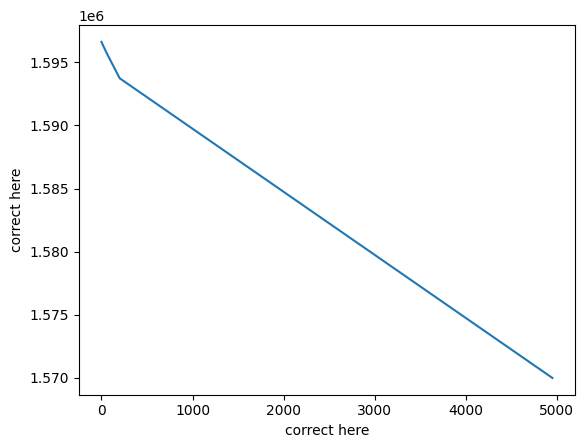

name 'results' is not defined


<Figure size 640x480 with 0 Axes>

In [7]:
%matplotlib inline
%run model_runner.py -Line71


### Analysis Line92
Kazemi will explain.


#### Code for Analysis Line92
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.


In [ ]:
def line92():
    depot_Tehran_min_to_recieve_change_list = []
    revenue_depend_on_tehran_min_to_recieve = []

    for capacity in range(20,65):
        instance.depots_min_to_receive['Tehran'] = capacity
        solver.solve(instance)
        revenue = instance.revenue()
        print(f"Tehran minimum receive: {capacity}, Revenue {instance.revenue()}, buy from Fac2: {instance.h[2]()}") 
        #print(new_capacity)
        revenue_depend_on_tehran_min_to_recieve.append(revenue)
        depot_Tehran_min_to_recieve_change_list.append(capacity)
    depot_Tehran_min_to_recieve_change_np = np.array(depot_Tehran_min_to_recieve_change_list)
    revenue_depend_on_tehran_max_to_recieve_np = np.array(revenue_depend_on_tehran_min_to_recieve)
    #TODO
    plt.xlabel("correct here")
    plt.ylabel("correct here")
    plt.plot(depot_Tehran_min_to_recieve_change_np, revenue_depend_on_tehran_max_to_recieve_np)
    plt.show()


#### Output
run the command below to see the result:

results for problem: -Line92
Tehran minimum receive: 30, Revenue 1592660.3030303018, buy from Fac2: 0.0


Tehran minimum receive: 31, Revenue 1592480.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 32, Revenue 1592300.3030303014, buy from Fac2: 0.0
Tehran minimum receive: 33, Revenue 1592120.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 34, Revenue 1591940.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 35, Revenue 1591760.3030303014, buy from Fac2: 0.0
Tehran minimum receive: 36, Revenue 1591580.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 37, Revenue 1591400.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 38, Revenue 1591220.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 39, Revenue 1591040.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 40, Revenue 1590860.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 41, Revenue 1590680.3030303018, buy from Fac2: 0.0
Tehran minimum receive: 42, Revenue 1590500.3030303014, buy from Fac2: 0.0
Tehran minimum receive: 43, Revenue 1590320.3030303014, buy from Fac2: 0.0
Tehran minimum receive: 4

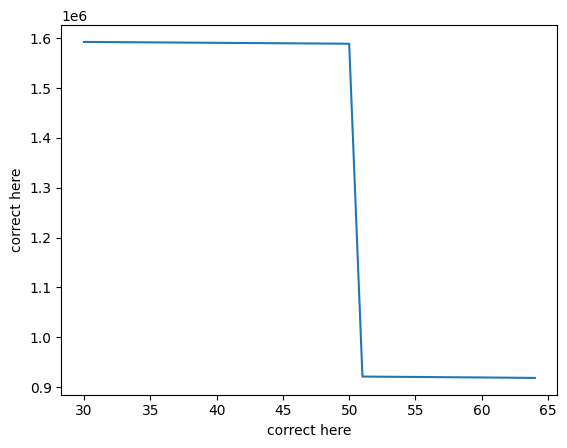

name 'results' is not defined


<Figure size 640x480 with 0 Axes>

In [6]:
%matplotlib inline
%run model_runner.py -Line92

### Analysis Line53
Kazemi will explain.


#### Code for Analysis Line53
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.


In [ ]:
def Line53():
        for cost in range(300, 400):
            instance.Price_of_ore_to_alloy = cost
            solver.solve(instance)
            print(f"Price of ore to alloy: {instance.Price_of_ore_to_alloy()}, Use Main?: {instance.h['Main']()}")


#### Output
run the command below to see the result:

In [10]:
!python model_runner.py -Line53

results for problem: -Line53
Price of ore to alloy: 300, Use Main?: 1.0
Price of ore to alloy: 301, Use Main?: 1.0
Price of ore to alloy: 302, Use Main?: 1.0
Price of ore to alloy: 303, Use Main?: 1.0
Price of ore to alloy: 304, Use Main?: 1.0
Price of ore to alloy: 305, Use Main?: 1.0
Price of ore to alloy: 306, Use Main?: 1.0
Price of ore to alloy: 307, Use Main?: 1.0
Price of ore to alloy: 308, Use Main?: 1.0
Price of ore to alloy: 309, Use Main?: 1.0
Price of ore to alloy: 310, Use Main?: 1.0
Price of ore to alloy: 311, Use Main?: 1.0
Price of ore to alloy: 312, Use Main?: 1.0
Price of ore to alloy: 313, Use Main?: 1.0
Price of ore to alloy: 314, Use Main?: 1.0
Price of ore to alloy: 315, Use Main?: 1.0
Price of ore to alloy: 316, Use Main?: 1.0
Price of ore to alloy: 317, Use Main?: 1.0
Price of ore to alloy: 318, Use Main?: 1.0
Price of ore to alloy: 319, Use Main?: 1.0
Price of ore to alloy: 320, Use Main?: 1.0
Price of ore to alloy: 321, Use Main?: 1.0
Price of ore to alloy: 32

### Analysis Line62
Kazemi will explain.


#### Code for Analysis Line62
the related python code for this problem is shown below, but you should run the model_runner.py to get the result.


In [ ]:
def Line62():
        instance.Price_of_ore_to_alloy = 0
        for cost in range(400, 550):
            instance.contract_cost[1] = 100 * cost
            solver.solve(instance)
            print(f"Fac1 contract cost: {instance.contract_cost[1]()}, Buy from Fac1: {instance.h[1]()}, Buy from Fac2: {instance.h[2]()}")


#### Output
run the command below to see the result:

In [13]:
!python model_runner.py -Line62

results for problem: -Line62
Fac1 contract cost: 40000, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40100, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40200, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40300, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40400, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40500, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40600, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40700, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40800, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 40900, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 41000, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 41100, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 41200, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 41300, But from Fac1: 1.0, Buy from Fac2: 0.0
Fac1 contract cost: 41400, But from Fac1: 1.0, 